<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%207/CaseStudy7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install scikit-learn-intelex


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
#from sklearnex import patch_sklearn
#patch_sklearn()
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict

from sklearn.utils import shuffle
from numpy import random
from itertools import product

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import DMatrix

from numpy import random
from itertools import product
from sklearn.utils import shuffle

import datetime
import pydot
import graphviz


2023-08-08 00:40:38.396448: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 00:40:39.049373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
#from google.colab import drive
#drive.mount('drive')

#df = pd.read_csv("drive/My Drive/final_project(5).csv")
df = pd.read_csv("/home/migue/Downloads/final_project(5).csv")

In [5]:
df.info()
#there are NAs will need handling

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 51 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      159974 non-null  float64
 1   x1      159975 non-null  float64
 2   x2      159962 non-null  float64
 3   x3      159963 non-null  float64
 4   x4      159974 non-null  float64
 5   x5      159963 non-null  float64
 6   x6      159974 non-null  float64
 7   x7      159973 non-null  float64
 8   x8      159979 non-null  float64
 9   x9      159970 non-null  float64
 10  x10     159957 non-null  float64
 11  x11     159970 non-null  float64
 12  x12     159964 non-null  float64
 13  x13     159969 non-null  float64
 14  x14     159966 non-null  float64
 15  x15     159965 non-null  float64
 16  x16     159974 non-null  float64
 17  x17     159973 non-null  float64
 18  x18     159960 non-null  float64
 19  x19     159965 non-null  float64
 20  x20     159962 non-null  float64
 21  x21     15

In [6]:
for i in df.columns:
    if df[i].isna().sum() > 0:
        print('{} has {}% NAs'.format(i,(df[i].isna().sum() / len(df))*100))

x0 has 0.01625% NAs
x1 has 0.015625% NAs
x2 has 0.02375% NAs
x3 has 0.023125% NAs
x4 has 0.01625% NAs
x5 has 0.023125% NAs
x6 has 0.01625% NAs
x7 has 0.016875% NAs
x8 has 0.013125% NAs
x9 has 0.01875% NAs
x10 has 0.026875% NAs
x11 has 0.01875% NAs
x12 has 0.0225% NAs
x13 has 0.019375% NAs
x14 has 0.021249999999999998% NAs
x15 has 0.021875000000000002% NAs
x16 has 0.01625% NAs
x17 has 0.016875% NAs
x18 has 0.025% NAs
x19 has 0.021875000000000002% NAs
x20 has 0.02375% NAs
x21 has 0.018125% NAs
x22 has 0.016875% NAs
x23 has 0.029375000000000002% NAs
x24 has 0.017499999999999998% NAs
x25 has 0.01375% NAs
x26 has 0.0225% NAs
x27 has 0.01875% NAs
x28 has 0.021875000000000002% NAs
x29 has 0.01875% NAs
x30 has 0.01875% NAs
x31 has 0.024374999999999997% NAs
x32 has 0.019375% NAs
x33 has 0.025625000000000002% NAs
x34 has 0.025625000000000002% NAs
x35 has 0.01875% NAs
x36 has 0.016875% NAs
x37 has 0.014374999999999999% NAs
x38 has 0.019375% NAs
x39 has 0.014374999999999999% NAs
x40 has 0.0225% NA

In [7]:
df['x24'].value_counts()

asia       138965
euorpe      16538
america      4469
Name: x24, dtype: int64

<BarContainer object of 3 artists>

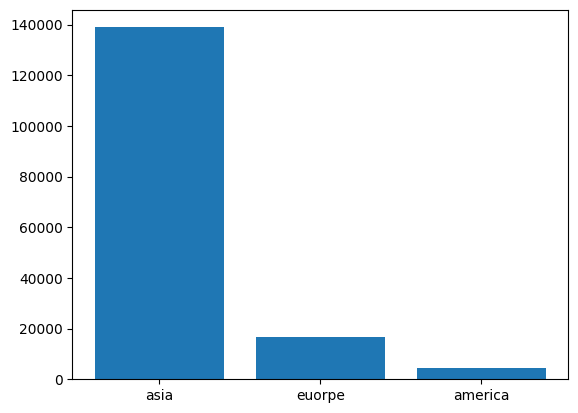

In [8]:
plt.bar(x=df['x24'].value_counts().index,height=df['x24'].value_counts().values)

In [9]:
df['x29'].value_counts()

July       45569
Jun        41329
Aug        29406
May        21939
sept.      10819
Apr         6761
Oct         2407
Mar         1231
Nov          337
Feb          140
Dev           23
January        9
Name: x29, dtype: int64

In [10]:
#clean up month formatting to standard 3 letters
df['x29'].replace(to_replace=['July','sept.','Dev','January'],value=['Jul','Sep','Dec','Jan'],inplace=True)

<BarContainer object of 12 artists>

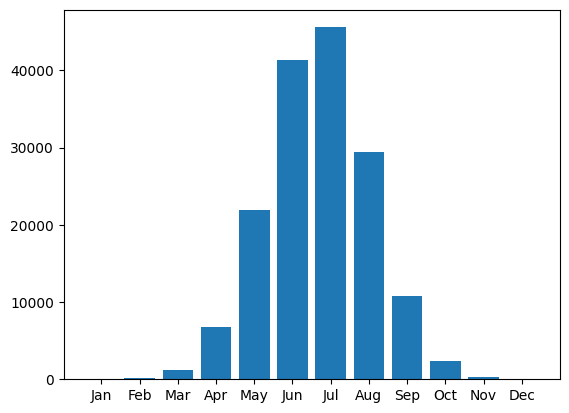

In [11]:
mo = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
heights = []
for i in mo:
    x = df['x29'].to_list().count(i)
    heights.append(x)
plt.bar(x=mo,height=heights)

Text(0.5, 0.98, 'Count plots for categorical features')

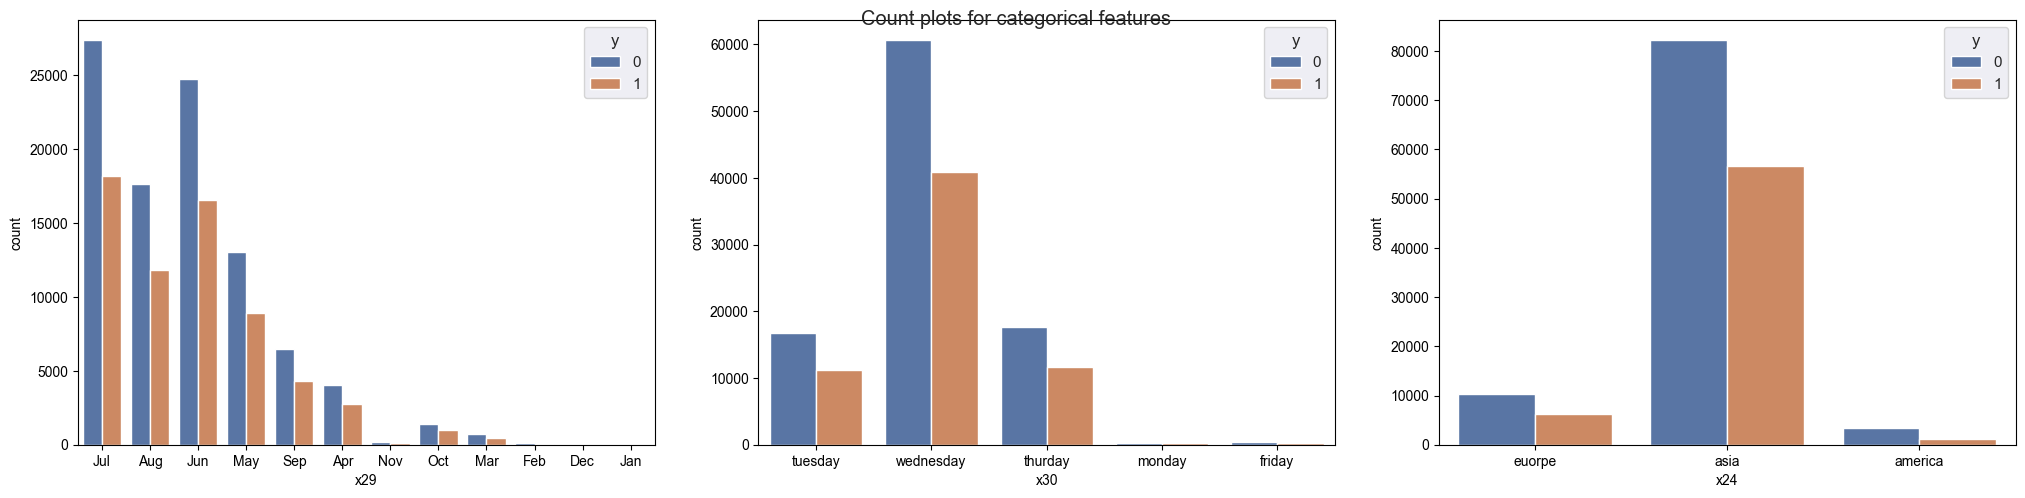

In [12]:
fig, axes = plt.subplots(1,3, figsize = (25, 5))
plt.subplots_adjust(wspace=.18,hspace=1)
fig.subplots_adjust(top = .96)
sns.set(rc={'figure.figsize':(5.5,6)})
sns.countplot(x = 'x29', data = df, hue = 'y', ax = axes[0]);
sns.countplot(x = 'x30', data = df, hue = 'y', ax = axes[1]);
sns.countplot(x = 'x24', data = df, hue = 'y', ax = axes[2]);

fig.suptitle('Count plots for categorical features')

In [13]:
df['x30'].value_counts()

wednesday    101535
thurday       29429
tuesday       27954
friday          564
monday          488
Name: x30, dtype: int64

<BarContainer object of 5 artists>

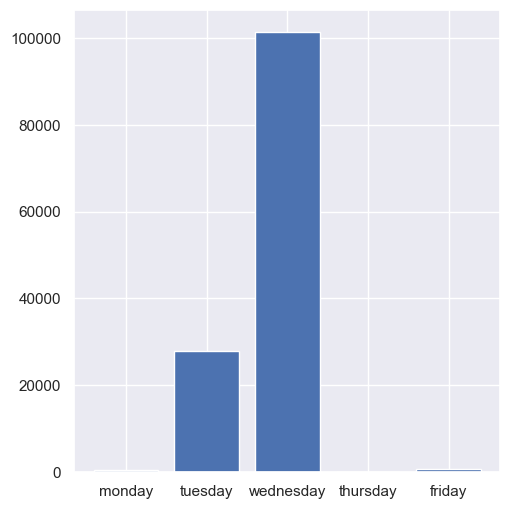

In [14]:
# thursday is incorrect
df['x30'].replace(to_replace = 'thurday',value='thursday')
days = ['monday','tuesday','wednesday','thursday','friday']
d_heights = []
for i in days:
    x = df['x30'].to_list().count(i)
    d_heights.append(x)
plt.bar(x=days,height = d_heights)

In [15]:
df['x32'].value_counts()

0.01%     40767
-0.01%    34094
0.0%      33923
-0.0%     30492
-0.02%     9924
0.02%      7987
-0.03%     1727
0.03%       855
-0.04%      138
0.04%        55
-0.05%        6
0.05%         1
Name: x32, dtype: int64

In [16]:
df['x37'].value_counts()


$-311.26     6
$-336.77     6
$237.4       6
$72.42       6
$341.26      6
            ..
$-505.21     1
$770.07      1
$74.62       1
$-1082.96    1
$-1229.34    1
Name: x37, Length: 129198, dtype: int64

In [17]:
### x32 and x37 are actually numeric with string format (even though x32 has few "levels" or possible values)
### x32 is in percentage, but don't think it needs to be transformed to proportion since data will be scaled later (will double check, but should make no difference)

df['x32'] = df['x32'].transform(lambda x: float(str(x).replace('%','')))
df['x37'] = df['x37'].transform(lambda x: float(str(x).replace('$','')))

In [18]:
#all significanlty less than 5%, should be no issue imputing,
#imputing categorical features with modes
# imputing continent with mode, then dates by mode grouped by continent

print('imputing continent with mode: {}'.format(df['x24'].aggregate(pd.Series.mode)))
df['x24'] = df['x24'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))

print('imputing month with mode by cont: {}'.format(df[['x24','x29']].groupby(by='x24').aggregate(pd.Series.mode)))
idx_29 = df.loc[df['x29'].isna(),:].index #saving NAs indices to quick check what they've been imputed with
df['x29'] = df[['x24','x29']].groupby(by='x24').transform(lambda grp: grp.fillna(pd.Series.mode(grp)[0]))

# will fix index showing on print later


imputing continent with mode: 0    asia
Name: x24, dtype: object
imputing month with mode by cont:          x29
x24         
america  Jul
asia     Jul
euorpe   Jul


In [19]:
df[['x24','x29','x30']].groupby(by=['x24','x29']).aggregate(pd.Series.mode)
# could just impute with wednesday since Wed is mode per month, but adding continent gives more context and different days for some months

x30
x24     x29           
america Apr  wednesday
        Aug  wednesday
        Feb    tuesday
        Jul  wednesday
        Jun  wednesday
        Mar  wednesday
        May  wednesday
        Nov  wednesday
        Oct  wednesday
        Sep  wednesday
asia    Apr  wednesday
        Aug  wednesday
        Dec  wednesday
        Feb  wednesday
        Jan  wednesday
        Jul  wednesday
        Jun  wednesday
        Mar  wednesday
        May  wednesday
        Nov  wednesday
        Oct  wednesday
        Sep  wednesday
euorpe  Apr  wednesday
        Aug  wednesday
        Dec  wednesday
        Feb    tuesday
        Jul  wednesday
        Jun  wednesday
        Mar  wednesday
        May  wednesday
        Nov  wednesday
        Oct  wednesday
        Sep  wednesday

In [20]:
# impute day
df['x30'] = df[['x24','x29','x30']].groupby(by=['x24','x29']).transform(lambda grp: grp.fillna(pd.Series.mode(grp)[0]))

In [21]:
df[['x24', 'x29', 'y']].groupby(['x24', 'x29']).mean()

y
x24     x29          
america Apr  0.234637
        Aug  0.273620
        Feb  0.250000
        Jul  0.243159
        Jun  0.248521
        Mar  0.351351
        May  0.285714
        Nov  0.200000
        Oct  0.212121
        Sep  0.235880
asia    Apr  0.414526
        Aug  0.408263
        Dec  0.450000
        Feb  0.385827
        Jan  0.333333
        Jul  0.407250
        Jun  0.407953
        Mar  0.397556
        May  0.410270
        Nov  0.438596
        Oct  0.410305
        Sep  0.404920
euorpe  Apr  0.379032
        Aug  0.372464
        Dec  0.666667
        Feb  0.444444
        Jul  0.374894
        Jun  0.383388
        Mar  0.392308
        May  0.387387
        Nov  0.476190
        Oct  0.461224
        Sep  0.400685

In [22]:
#created categorical variable for high/low volume based on month/continent
conditions = [
    (df['x24'] == 'america'),
    (df['x24'] =='asia'),
    (df['x24'] =='euorpe')
    ]

values = ['low', 'high', 'high']
df['Volume'] = np.select(conditions, values)
df[['Volume', 'y']].groupby(['Volume']).count()

,y
Volume,
high,155531
low,4469


In [23]:
X = df.loc[:,df.columns != 'y']
y = df['y'].values.flatten()

df_num = X.select_dtypes(exclude='object')
num_cols = df_num.columns

# impute numeric with median
for i in num_cols:
    df_num[i] = df_num[i].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))
df_num.info()

df_cat = X.select_dtypes(include='object')
cat_cols = df_cat.columns

# scale numerical data
scaler = StandardScaler()
df_num = scaler.fit_transform(df_num)

#one hot encode cat data
encoder = OneHotEncoder(sparse_output=False)
df_cat = encoder.fit_transform(df_cat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 47 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      160000 non-null  float64
 1   x1      160000 non-null  float64
 2   x2      160000 non-null  float64
 3   x3      160000 non-null  float64
 4   x4      160000 non-null  float64
 5   x5      160000 non-null  float64
 6   x6      160000 non-null  float64
 7   x7      160000 non-null  float64
 8   x8      160000 non-null  float64
 9   x9      160000 non-null  float64
 10  x10     160000 non-null  float64
 11  x11     160000 non-null  float64
 12  x12     160000 non-null  float64
 13  x13     160000 non-null  float64
 14  x14     160000 non-null  float64
 15  x15     160000 non-null  float64
 16  x16     160000 non-null  float64
 17  x17     160000 non-null  float64
 18  x18     160000 non-null  float64
 19  x19     160000 non-null  float64
 20  x20     160000 non-null  float64
 21  x21     16

In [24]:
X = np.hstack([df_num,df_cat])

In [25]:
X.shape

(160000, 69)

In [26]:
df['y'].value_counts() # not balanced

0    95803
1    64197
Name: y, dtype: int64

In [27]:
## define cost function
def cost_func(y_pred,y_true):
    diff = y_pred - y_true
    x = 0
    for i in diff:
        #false pos (y_pred -y_true == 1)
        if i == 1:
            x += 100
        #false neg (y_pred -y_true ==-1)
        elif i == -1:
            x += 150
    return(x)

In [28]:
#stratifiedkfold by high/lower volume created category
#in order to get an equal distribution of the 0s during high volume time and 1s during low, replace with binary imediately after

y=df[['Volume', 'y']].astype(str).apply("-".join, axis=1)
skf = StratifiedKFold(n_splits=10,random_state=807,shuffle=True)
skf.get_n_splits(X,y)
y = df['y'].values.flatten()

### Logistic Regression

In [ ]:
#logR = LogisticRegression(random_state=807,penalty='elasticnet',class_weight='balanced',solver='saga')
#params = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,2,5,10],'l1_ratio':[0,0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99,1],'max_iter':[25,50,75]}

#lr_clf = GridSearchCV(estimator=logR,param_grid=params,n_jobs=-1,cv=skf)
#lr_clf.fit(X,y)

In [ ]:
#lr_params = lr_clf.best_params_
lr_params ={'C': 0.001, 'l1_ratio': 0.5, 'max_iter': 50}

{'C': 0.001, 'l1_ratio': 0.5, 'max_iter': 50}

In [ ]:
model1 = LogisticRegression(random_state=807,penalty='elasticnet',class_weight='balanced',solver='saga')
model1.set_params(**lr_params)
model1.fit(X,y)

preds_m1 = cross_val_predict(model1,X,y,cv=skf)

In [ ]:
cr_m1 = classification_report(y,preds_m1,output_dict=True)
cr_m1

{'0': {'precision': 0.7707427436265313,
  'recall': 0.7289646462010584,
  'f1-score': 0.7492717782558083,
  'support': 95803},
 '1': {'precision': 0.625796224239804,
  'recall': 0.6764179011480287,
  'f1-score': 0.6501231407247711,
  'support': 64197},
 'accuracy': 0.70788125,
 'macro avg': {'precision': 0.6982694839331676,
  'recall': 0.7026912736745435,
  'f1-score': 0.6996974594902896,
  'support': 160000},
 'weighted avg': {'precision': 0.7125856704698453,
  'recall': 0.70788125,
  'f1-score': 0.7094902464834333,
  'support': 160000}}

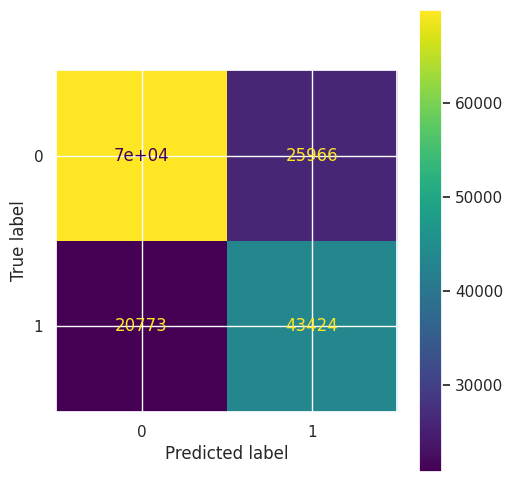

In [ ]:
ConfusionMatrixDisplay.from_predictions(y,preds_m1)

In [ ]:
cost_m1 = cost_func(preds_m1,y)
cost_m1

5712550

### Random Forest

In [ ]:
#rf = RandomForestClassifier(random_state=807,criterion='gini',class_weight='balanced')
#params = {'n_estimators':[100, 200],'max_features':['sqrt','log2',20]}
#rf_clf = GridSearchCV(rf,param_grid=params,cv=skf,n_jobs = -1)

In [ ]:
#rf_clf.fit(X,y)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=807, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=807),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', 20],
                         'n_estimators': [100, 200]})

In [ ]:
#rf_clf.best_params_

{'max_features': 20, 'n_estimators': 200}

In [ ]:
rf_params = {'max_features': 20, 'n_estimators': 200}
rf_params

{'max_features': 20, 'n_estimators': 200}

In [ ]:
model2 = RandomForestClassifier(random_state=807,criterion='gini',class_weight='balanced')
model2.set_params(**rf_params)
preds_m2 = cross_val_predict(model2,X,y,cv=skf)

KeyboardInterrupt: ignored

In [ ]:
preds_m2 = pd.read_csv("/content/rf_results.csv")
preds_m2 = preds_m2['0']
preds_m2

In [ ]:
preds_m2 = preds_m2['0']

In [ ]:
cr_m2 = classification_report(y,preds_m2,output_dict=True)
cr_m2

{'0': {'precision': 0.9305797512457967,
  'recall': 0.9590305105268102,
  'f1-score': 0.9445909476443828,
  'support': 95803},
 '1': {'precision': 0.9359371939674871,
  'recall': 0.8932348863654065,
  'f1-score': 0.914087594149763,
  'support': 64197},
 'accuracy': 0.93263125,
 'macro avg': {'precision': 0.933258472606642,
  'recall': 0.9261326984461083,
  'f1-score': 0.9293392708970729,
  'support': 160000},
 'weighted avg': {'precision': 0.932729324685824,
  'recall': 0.93263125,
  'f1-score': 0.9323520489925445,
  'support': 160000}}

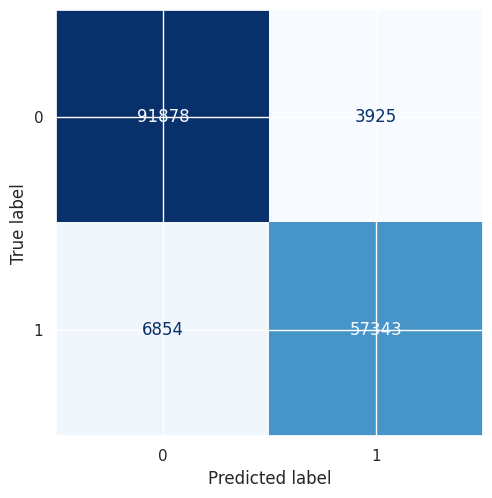

In [ ]:
ConfusionMatrixDisplay.from_predictions(y,preds_m2 ,cmap='Blues', colorbar=False)

In [ ]:
cost_m2 = cost_func(preds_m2,y)
cost_m2

1420600

### XGBoost

In [ ]:
#setting up a hyperparameter dataframe

learning_rates = [0.1, 0.25, 0.35]
max_depths = [3, 5, 10, 20]
gamma = [0,1,3]
lambda_ls = [1,2,3]
alpha = [0,0.1,1]

xgb_param = pd.DataFrame(list(product(learning_rates, max_depths, gamma, lambda_ls, alpha)), columns=['learning_rate', 'max_depth', 'gamma', 'lambda', 'alpha'])

#randomizing the dataframe order
xgb_param = shuffle(xgb_param)
xgb_param = xgb_param.reset_index()
xgb_param=xgb_param.drop(['index'], axis=1)
xgb_param

,learning_rate,max_depth,gamma,lambda,alpha
0,0.10,20,3,1,0.0
1,0.25,20,1,3,0.0
2,0.35,20,1,3,0.0
3,0.35,3,0,2,0.0
4,0.25,5,3,1,0.1
...,...,...,...,...,...
319,0.25,20,0,3,0.1
320,0.10,3,1,2,1.0
321,0.25,10,3,2,1.0
322,0.25,5,1,1,0.0


In [ ]:
dtrain = xgb.DMatrix(X[train_index], label=y[train_index])
dtest = xgb.DMatrix(X[test_index], label=y[test_index])

trials = 30
best_params = {}
i=0

for i in range(trials):
  #random sampling from paramdf
  hyperparams = {'objective': 'binary:logistic',
                 'eta': xgb_param['learning_rate'][i],
                 'max_depth': xgb_param['max_depth'][i],
                 'gamma': xgb_param['gamma'][i],
                 'lambda': xgb_param['lambda'][i],
                 'alpha': xgb_param['alpha'][i],
                 'eval_metric': 'aucpr'
                 }

  print(hyperparams)
  out=xgb.cv(params=hyperparams,
             num_boost_round=20,
             dtrain=dtrain,
             nfold=5,
             stratified=True,
             early_stopping_rounds=3,
             verbose_eval=1
             )

  index=out.shape[0]-1
  result=out.iloc[index,2]
  if i< 1.1:
    best_result = result
    best_params = hyperparams

  if result> best_result:
      best_result = result
      best_params = hyperparams
      print('result: ' ,result)
      print('best result: ' ,best_result)
      print('hyperparameters: ' ,hyperparams)
      print('best hyperparameters: ' ,best_params)
      i+=1

{'objective': 'binary:logistic', 'eta': 0.25, 'max_depth': 3, 'gamma': 0, 'lambda': 2, 'alpha': 0.1, 'eval_metric': 'aucpr'}
[0]	train-aucpr:0.64563+0.00181	test-aucpr:0.64315+0.00505
[1]	train-aucpr:0.69980+0.00174	test-aucpr:0.69633+0.00534
[2]	train-aucpr:0.72409+0.00755	test-aucpr:0.71974+0.01007
[3]	train-aucpr:0.73761+0.00208	test-aucpr:0.73401+0.00555
[4]	train-aucpr:0.74850+0.00132	test-aucpr:0.74449+0.00515
[5]	train-aucpr:0.75308+0.00284	test-aucpr:0.74841+0.00202
[6]	train-aucpr:0.76401+0.00358	test-aucpr:0.75897+0.00562
[7]	train-aucpr:0.77443+0.00387	test-aucpr:0.76929+0.00501
[8]	train-aucpr:0.78353+0.00227	test-aucpr:0.77830+0.00214
[9]	train-aucpr:0.79100+0.00270	test-aucpr:0.78574+0.00044
[10]	train-aucpr:0.79796+0.00160	test-aucpr:0.79272+0.00191
[11]	train-aucpr:0.80414+0.00166	test-aucpr:0.79894+0.00328
[12]	train-aucpr:0.80805+0.00231	test-aucpr:0.80253+0.00271
[13]	train-aucpr:0.81465+0.00377	test-aucpr:0.80908+0.00378
[14]	train-aucpr:0.81993+0.00351	test-aucpr:0

In [ ]:
best_params

{'objective': 'binary:logistic',
 'eta': 0.25,
 'max_depth': 20,
 'gamma': 1,
 'lambda': 1,
 'alpha': 1.0,
 'eval_metric': 'aucpr'}

In [ ]:
aucpr_params = {'objective': 'binary:logistic',
         'eta': 0.25,
         'max_depth': 20,
         'gamma': 1,
         'lambda': 1,
         'alpha': 1.0,
         'eval_metric': 'aucpr'}

In [ ]:
fold_results = {}

for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    dtrain = xgb.DMatrix(X[train_index], label=y[train_index])
    dtest = xgb.DMatrix(X[test_index], label=y[test_index])
    evallist = [(dtrain, 'train'), (dtest, 'eval')]

    tr=xgb.train(params=aucpr_params,
                 num_boost_round=222,
                 dtrain=dtrain,
                 verbose_eval=1,
                 evals=evallist,
                 early_stopping_rounds = 3
             )

    preds_XGB = np.round(tr.predict(dtest), 0)

    classification_report(y[test_index],np.round(preds_XGB, 0),output_dict=True)
    fold_results.update({i:{'predictions':preds_XGB,'index':test_index,'y_true':y[test_index]}})

[0]	train-aucpr:0.95959	eval-aucpr:0.89759
[1]	train-aucpr:0.98119	eval-aucpr:0.93133
[2]	train-aucpr:0.98777	eval-aucpr:0.93999
[3]	train-aucpr:0.99178	eval-aucpr:0.94840
[4]	train-aucpr:0.99375	eval-aucpr:0.95154
[5]	train-aucpr:0.99507	eval-aucpr:0.95507
[6]	train-aucpr:0.99611	eval-aucpr:0.95924
[7]	train-aucpr:0.99678	eval-aucpr:0.96071
[8]	train-aucpr:0.99724	eval-aucpr:0.96271
[9]	train-aucpr:0.99786	eval-aucpr:0.96437
[10]	train-aucpr:0.99815	eval-aucpr:0.96569
[11]	train-aucpr:0.99847	eval-aucpr:0.96755
[12]	train-aucpr:0.99871	eval-aucpr:0.96863
[13]	train-aucpr:0.99891	eval-aucpr:0.96901
[14]	train-aucpr:0.99905	eval-aucpr:0.97010
[15]	train-aucpr:0.99918	eval-aucpr:0.97096
[16]	train-aucpr:0.99930	eval-aucpr:0.97178
[17]	train-aucpr:0.99940	eval-aucpr:0.97243
[18]	train-aucpr:0.99945	eval-aucpr:0.97295
[19]	train-aucpr:0.99952	eval-aucpr:0.97329
[20]	train-aucpr:0.99959	eval-aucpr:0.97385
[21]	train-aucpr:0.99964	eval-aucpr:0.97411
[22]	train-aucpr:0.99969	eval-aucpr:0.9742

In [ ]:
preds_m3 = np.zeros(len(y))
for i in fold_results.keys():
  for j in range(len(fold_results.get(i).get('predictions'))):
    idx = fold_results.get(i).get('index')[j]
    preds_m3[idx] = np.round(fold_results.get(i).get('predictions')[j], 0)

In [ ]:
m3_cost = cost_func(preds_m3,y)
m3_cost

1164650

In [ ]:
preds_new3 = np.zeros(len(y))
for i in fold_results.keys():
  for j in range(len(fold_results.get(i).get('predictions'))):
    idx = fold_results.get(i).get('index')[j]
    if fold_results.get(i).get('predictions')[j] > 0.65:
      preds_new3[idx] = 1
    else:
      preds_new3[idx] = 0
m3_cost_t = cost_func(y,preds_new3)
m3_cost_t

1100600

### Neural Network

In [ ]:
#sets binary values for predictions
def cost(y_true,y_pred):

  bin_p = K.switch(K.greater_equal(y_pred,0.5),K.constant(1,shape=y_pred.shape),
                   K.constant(0,shape=y_pred.shape))
  diff = bin_p-y_true

  error = K.switch(
      K.equal(diff,1),K.constant(100,shape=y_pred.shape),
      K.switch(
          K.equal(diff,-1),K.constant(150,shape=y_pred.shape),
          K.constant(0,shape=y_pred.shape)
      )
  )
  return(K.sum(error))

In [ ]:
### define a cost function used in validation with keras and backend
### returns the average cost (total cost divided by array tensor size)
def cost(y_true,y_pred):
  bin_p = tf.where(tf.greater_equal(y_pred,0.5),tf.constant(1,dtype='float32'),tf.constant(0,dtype='float32'))

  diff = bin_p - y_true

  error = tf.where(
      tf.equal(diff,1),100,
      tf.where(
          tf.equal(diff,-1),150,
          0
      )
  )
  return(K.sum(error)/tf.size(bin_p))

In [ ]:
#updated to cost instead of val_cost, and saw cost lowered
es = EarlyStopping(monitor='cost', mode='min',patience=50,restore_best_weights=True,start_from_epoch=100)
fold_results = {}
t_tot = now()
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  # building model within loop to reset weights each time
  tf.keras.backend.clear_session()
  tf.keras.utils.set_random_seed(807)
  model4 = tf.keras.Sequential()
  model4.add(tf.keras.Input(shape=(X.shape[1],)))
  model4.add(tf.keras.layers.Dense(64, activation='relu',name="Relu1"))
  model4.add(tf.keras.layers.Dense(64, activation='relu', name="Relu2"))
  model4.add(tf.keras.layers.Dropout(0.4))
  model4.add(tf.keras.layers.Dense(1, activation='sigmoid', name="Activation"))
  model4.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics = [tf.keras.metrics.AUC(from_logits=False, curve='PR'), 'accuracy',cost])
  t_fold = now()
  print('x_train shape:', X[train_index].shape)
  model4.fit(X[train_index],y[train_index],epochs=1000,batch_size=1024,validation_split=0.1,callbacks=[es])
  score = model4.evaluate(X[test_index],y[test_index])
  fold_results.update({i:{'predictions':model4.predict(X[test_index]).flatten(),'index':test_index,'y_true':y[test_index]}})
  print('fold train/predict time: %s' % (now()-t_fold))
  print('fold accuracy: {} - fold cost: {}'.format(score[2],score[3]))
  print('total train/predict time: %s' % (now()-t_tot))

Streaming output truncated to the last 5000 lines.
Epoch 30/1000
127/127 [==============================] - 1s 4ms/step - loss: 0.1215 - auc: 0.9847 - accuracy: 0.9606 - cost: 5.0143 - val_loss: 0.1295 - val_auc: 0.9822 - val_accuracy: 0.9579 - val_cost: 5.6999
Epoch 31/1000
127/127 [==============================] - 1s 4ms/step - loss: 0.1185 - auc: 0.9852 - accuracy: 0.9616 - cost: 4.8743 - val_loss: 0.1278 - val_auc: 0.9819 - val_accuracy: 0.9597 - val_cost: 5.2897
Epoch 32/1000
127/127 [==============================] - 1s 4ms/step - loss: 0.1177 - auc: 0.9854 - accuracy: 0.9623 - cost: 4.8102 - val_loss: 0.1247 - val_auc: 0.9825 - val_accuracy: 0.9606 - val_cost: 5.3353
Epoch 33/1000
127/127 [==============================] - 1s 4ms/step - loss: 0.1159 - auc: 0.9858 - accuracy: 0.9627 - cost: 4.7421 - val_loss: 0.1265 - val_auc: 0.9825 - val_accuracy: 0.9599 - val_cost: 5.5957
Epoch 34/1000
127/127 [==============================] - 1s 4ms/step - loss: 0.1150 - auc: 0.9859 - accur

In [ ]:
m4_results = fold_results

In [ ]:
preds_m4 = np.zeros(len(y))
for i in m4_results.keys():
  for j in range(len(m4_results.get(i).get('predictions'))):
    idx = m4_results.get(i).get('index')[j]
    preds_m4[idx] = (m4_results.get(i).get('predictions')[j])

In [ ]:
preds_new4 = np.zeros(len(y))
for i in m4_results.keys():
  for j in range(len(m4_results.get(i).get('predictions'))):
    idx = m4_results.get(i).get('index')[j]
    if m4_results.get(i).get('predictions')[j] > 0.6:
      preds_new4[idx] = 1
    else:
      preds_new4[idx] = 0
m4_cost_t = cost_func(y,preds_new4)
m4_cost_t

541700

In [ ]:
model4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Relu1 (Dense)               (None, 64)                4480      
                                                                 
 Relu2 (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Activation (Dense)          (None, 1)                 65        
                                                                 
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4.save('model4.keras')

In [ ]:
es = EarlyStopping(monitor='val_cost', mode='min',patience=50,restore_best_weights=True,start_from_epoch=100)
fold_results = {}
t_tot = now()
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  # building model within loop to reset weights each time
  tf.keras.backend.clear_session()
  tf.keras.utils.set_random_seed(807)
  model5 = tf.keras.Sequential()
  model5.add(tf.keras.Input(shape=(X.shape[1],)))
  model5.add(tf.keras.layers.Dense(64, activation='relu',name="Relu1"))
  model5.add(tf.keras.layers.Dense(64, activation='relu', name="Relu2"))
  model5.add(tf.keras.layers.Dropout(0.2))
  model5.add(tf.keras.layers.Dense(1, activation='sigmoid', name="Activation"))
  model5.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics = [tf.keras.metrics.AUC(from_logits=False), 'accuracy',cost])
  t_fold = now()
  print('x_train shape:', X[train_index].shape)
  model5.fit(X[train_index],y[train_index],epochs=1000,batch_size=1024,validation_split=0.1,callbacks=[es])
  score = model5.evaluate(X[test_index],y[test_index])
  fold_results.update({i:{'predictions':model5.predict(X[test_index]).flatten(),'index':test_index,'y_true':y[test_index]}})
  print('fold train/predict time: %s' % (now()-t_fold))
  print('fold accuracy: {} - fold cost: {}'.format(score[2],score[3]))
print('total train/predict time: %s' % (now()-t_tot))

x_train shape: (144000, 69)
Epoch 1/1000
127/127 [==============================] - 2s 6ms/step - loss: 0.5265 - auc: 0.8009 - accuracy: 0.7294 - cost: 35.9773 - val_loss: 0.3919 - val_auc: 0.9022 - val_accuracy: 0.8288 - val_cost: 21.9434
Epoch 2/1000
127/127 [==============================] - 1s 4ms/step - loss: 0.3471 - auc: 0.9236 - accuracy: 0.8525 - cost: 18.7994 - val_loss: 0.3144 - val_auc: 0.9371 - val_accuracy: 0.8675 - val_cost: 16.4290
Epoch 3/1000
127/127 [==============================] - 1s 4ms/step - loss: 0.3006 - auc: 0.9428 - accuracy: 0.8754 - cost: 15.7626 - val_loss: 0.2882 - val_auc: 0.9483 - val_accuracy: 0.8802 - val_cost: 15.3288
Epoch 4/1000
127/127 [==============================] - 1s 4ms/step - loss: 0.2716 - auc: 0.9533 - accuracy: 0.8896 - cost: 13.9979 - val_loss: 0.2613 - val_auc: 0.9572 - val_accuracy: 0.8955 - val_cost: 12.6530
Epoch 5/1000
127/127 [==============================] - 1s 4ms/step - loss: 0.2487 - auc: 0.9609 - accuracy: 0.9009 - cost: 

In [ ]:
m5_results = fold_results

In [ ]:
preds_m5 = np.zeros(len(y))
for i in fold_results.keys():
  for j in range(len(fold_results.get(i).get('predictions'))):
    idx = fold_results.get(i).get('index')[j]
    preds_m5[idx] = np.round(fold_results.get(i).get('predictions')[j],0)

m5_cost = cost_func(y,preds_m5)
m5_cost

579600

In [ ]:
preds_new5 = np.zeros(len(y))
for i in m5_results.keys():
  for j in range(len(m5_results.get(i).get('predictions'))):
    idx = m5_results.get(i).get('index')[j]
    if m5_results.get(i).get('predictions')[j] > 0.6:
      preds_new5[idx] = 1
    else:
      preds_new5[idx] = 0

m5_cost_t = cost_func(y,preds_new5)
m5_cost_t

561100

In [ ]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Relu1 (Dense)               (None, 64)                4480      
                                                                 
 Relu2 (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Activation (Dense)          (None, 1)                 65        
                                                                 
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model5.save('model5.keras')

In [ ]:
from google.colab import files

y_alt = pd.DataFrame()

#one hot encoding categorical variables for model
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols = list((set(cols) - set(num_cols)))

#creating dataframe of categorical columns
cat_df = df[cat_cols]
cat_df = pd.get_dummies(cat_df, columns=cat_df.columns,sparse=True)
cat_df

y_alt['Volume_high']= cat_df['Volume_high']
y_alt['preds_m1']=preds_m1
y_alt['preds_m2']=preds_m2
y_alt['preds_m3']=preds_m3
y_alt['preds_m4']=preds_m4
y_alt['preds_m5']=preds_m5

y_alt['preds_new4']=preds_new4
y_alt['preds_new5']=preds_new5


y_alt.to_csv('results.csv', encoding = 'utf-8-sig')
files.download('results.csv')

<ipython-input-180-10daa75af518>:26: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  y_alt.to_csv('results.csv', encoding = 'utf-8-sig')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_alt

,Volume_high,preds_m1,preds_m2,preds_m3,preds_m4,preds_m5,preds_new4,preds_new5
0,1,0,0,0.0,0.0,0.0,0.0,0.0
1,1,1,0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0.0,0.0,0.0,0.0,0.0
3,1,1,1,1.0,0.0,0.0,0.0,0.0
4,1,1,1,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
159995,1,1,1,1.0,1.0,1.0,1.0,1.0
159996,1,0,0,0.0,0.0,0.0,0.0,0.0
159997,1,1,0,0.0,1.0,0.0,1.0,0.0
159998,1,0,0,0.0,0.0,0.0,0.0,0.0


### Results

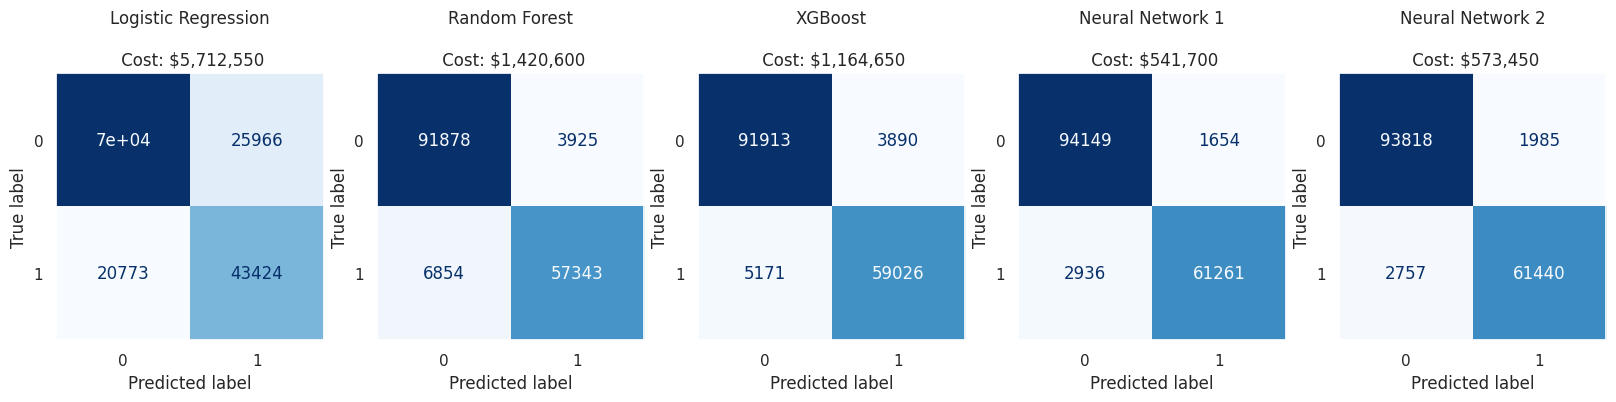

In [ ]:
#Confusion Matrix of Results

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt


cm_preds_m1 = confusion_matrix(y,preds_m1)
cm_preds_m2 = confusion_matrix(y,preds_m2)
cm_preds_m3 = confusion_matrix(y,preds_m3)
cm_preds_m4 = confusion_matrix(y,preds_new4)
cm_preds_m5 = confusion_matrix(y,preds_new5)

fig, ax = plt.subplots(1,5,figsize= (20,4))

disp1 = ConfusionMatrixDisplay(cm_preds_m1).plot(ax = ax[0],cmap = 'Blues', colorbar=False)
ax[0].set_title('Logistic Regression'+ '\n\n' + ' Cost: '+ '$'+ str(f'{cost_m1:,}'), fontsize = 12)
ax[0].grid(False)

disp2 = ConfusionMatrixDisplay(cm_preds_m2).plot(ax= ax[1],cmap='Blues', colorbar=False)
ax[1].set_title('Random Forest'+ '\n\n' + ' Cost: '+ '$'+ str(f'{cost_m2:,}'), fontsize = 12)
ax[1].grid(False)


disp3 = ConfusionMatrixDisplay(cm_preds_m3).plot(ax= ax[2],cmap='Blues', colorbar=False)
ax[2].set_title('XGBoost'+ '\n\n' + ' Cost: '+ '$'+ str(f'{m3_cost:,}'), fontsize = 12)
ax[2].grid(False)

disp4 = ConfusionMatrixDisplay(cm_preds_m4).plot(ax= ax[3],cmap='Blues', colorbar=False)
ax[3].set_title('Neural Network 1'+ '\n\n' + ' Cost: '+ '$'+ str(f'{m4_cost_t:,}'), fontsize = 12)
ax[3].grid(False)

disp5 = ConfusionMatrixDisplay(cm_preds_m5).plot(ax= ax[4],cmap='Blues', colorbar=False)
ax[4].set_title('Neural Network 2'+ '\n\n' + ' Cost: '+ '$'+ str(f'{m5_cost_t:,}'), fontsize = 12)
ax[4].grid(False)



plt.show()

### Running an Extra Validation for Model 4 (retrain/test out of fold), which had the best results

In [ ]:
### Running an Extra Validation for Model 4 (retrain/test out of fold), which had the best results

X = df.loc[:,df.columns != 'y']
y = df['y'].values.flatten()

df_num = X.select_dtypes(exclude='object')
num_cols = df_num.columns

# impute numeric with median
for i in num_cols:
    df_num[i] = df_num[i].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))

df_cat = X.select_dtypes(include='object')
cat_cols = df_cat.columns

# scale numerical data
scaler = StandardScaler()
df_num = scaler.fit_transform(df_num)

#one hot encode cat data
encoder = OneHotEncoder(sparse_output=False)
df_cat = encoder.fit_transform(df_cat)
X = np.hstack([df_num,df_cat])


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y, train_size=0.9, test_size=0.1)

now = datetime.datetime.now

#Extra validation for model 4
#updated to cost instead of val_cost, and saw cost lowered
es = EarlyStopping(monitor='cost', mode='min',patience=50,restore_best_weights=True,start_from_epoch=100)
fold_results = {}
t_tot = now()

skf = StratifiedKFold(n_splits=10,random_state=807,shuffle=True)
skf.get_n_splits(X_train,y_train)

for i, (train_index, test_index) in enumerate(skf.split(X_train,y_train)):
 # building model within loop to reset weights each time
  tf.keras.backend.clear_session()
  tf.keras.utils.set_random_seed(807)
  model4 = tf.keras.Sequential()
  model4.add(tf.keras.Input(shape=(X.shape[1],)))
  model4.add(tf.keras.layers.Dense(64, activation='relu',name="Relu1"))
  model4.add(tf.keras.layers.Dense(64, activation='relu', name="Relu2"))

  model4.add(tf.keras.layers.Dropout(0.2))
  model4.add(tf.keras.layers.Dense(1, activation='sigmoid', name="Activation"))
  model4.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics = [tf.keras.metrics.AUC(from_logits=False, curve='PR'), 'accuracy',cost])
  t_fold = now()
  model4.fit(X_train[train_index],y_train[train_index],epochs=1000,batch_size=1024,validation_split=0.1,callbacks=[es])
  score = model4.evaluate(X_train[test_index],y_train[test_index])
  fold_results.update({i:{'predictions':model4.predict(X_train[test_index]).flatten(),'index':test_index,'y_true':y_train[test_index]}})
  print('fold train/predict time: %s' % (now()-t_fold))
  print('fold accuracy: {} - fold cost: {}'.format(score[2],score[3]))
  print('total train/predict time: %s' % (now()-t_tot))

Streaming output truncated to the last 5000 lines.
114/114 [==============================] - 1s 5ms/step - loss: 0.0645 - auc: 0.9938 - accuracy: 0.9807 - cost: 2.4704 - val_loss: 0.1185 - val_auc: 0.9837 - val_accuracy: 0.9687 - val_cost: 4.0093
Epoch 144/1000
114/114 [==============================] - 1s 5ms/step - loss: 0.0649 - auc: 0.9938 - accuracy: 0.9806 - cost: 2.4630 - val_loss: 0.1156 - val_auc: 0.9841 - val_accuracy: 0.9683 - val_cost: 3.9946
Epoch 145/1000
114/114 [==============================] - 1s 5ms/step - loss: 0.0653 - auc: 0.9937 - accuracy: 0.9805 - cost: 2.5071 - val_loss: 0.1175 - val_auc: 0.9832 - val_accuracy: 0.9680 - val_cost: 4.0009
Epoch 146/1000
114/114 [==============================] - 1s 5ms/step - loss: 0.0644 - auc: 0.9939 - accuracy: 0.9809 - cost: 2.4320 - val_loss: 0.1175 - val_auc: 0.9836 - val_accuracy: 0.9688 - val_cost: 3.9379
Epoch 147/1000
114/114 [==============================] - 1s 5ms/step - loss: 0.0652 - auc: 0.9939 - accuracy: 0.980

### Estimated Cost for additional out of fold validation

In [ ]:
X_pred = model4.predict(X_test)
X_pred = np.round(X_pred, 0)
X_pred = pd.DataFrame(X_pred)
m4_cost_oo = cost_func(y_test,X_pred[0])
m4_cost_oo

500/500 [==============================] - 1s 1ms/step


63800

In [ ]:
m4_cost_oo*9

574200

In [ ]:
es = EarlyStopping(monitor='val_cost', mode='min',patience=50,restore_best_weights=True,start_from_epoch=100)
fold_results = {}
t_tot = now()
for i, (train_index, test_index) in enumerate(skf.split(X_train,y_train)):
  # building model within loop to reset weights each time
  tf.keras.backend.clear_session()
  tf.keras.utils.set_random_seed(807)
  model5 = tf.keras.Sequential()
  model5.add(tf.keras.Input(shape=(X.shape[1],)))
  model5.add(tf.keras.layers.Dense(64, activation='relu',name="Relu1"))
  model5.add(tf.keras.layers.Dense(64, activation='relu', name="Relu2"))
  model5.add(tf.keras.layers.Dropout(0.2))
  model5.add(tf.keras.layers.Dense(1, activation='sigmoid', name="Activation"))
  model5.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics = [tf.keras.metrics.AUC(from_logits=False), 'accuracy',cost])
  t_fold = now()
  print('x_train shape:', X_train[train_index].shape)
  model5.fit(X_train[train_index],y_train[train_index],epochs=1000,batch_size=1024,validation_split=0.1,callbacks=[es])
  score = model5.evaluate(X_train[test_index],y_train[test_index])
  fold_results.update({i:{'predictions':model5.predict(X_train[test_index]).flatten(),'index':test_index,'y_true':y_train[test_index]}})
  print('fold train/predict time: %s' % (now()-t_fold))
  print('fold accuracy: {} - fold cost: {}'.format(score[2],score[3]))
print('total train/predict time: %s' % (now()-t_tot))

x_train shape: (129600, 69)
Epoch 1/1000
114/114 [==============================] - 2s 6ms/step - loss: 0.5383 - auc: 0.7895 - accuracy: 0.7225 - cost: 37.0345 - val_loss: 0.4186 - val_auc: 0.8882 - val_accuracy: 0.8124 - val_cost: 24.2606
Epoch 2/1000
114/114 [==============================] - 0s 4ms/step - loss: 0.3598 - auc: 0.9175 - accuracy: 0.8452 - cost: 19.7973 - val_loss: 0.3302 - val_auc: 0.9309 - val_accuracy: 0.8600 - val_cost: 17.6314
Epoch 3/1000
114/114 [==============================] - 0s 4ms/step - loss: 0.3079 - auc: 0.9399 - accuracy: 0.8711 - cost: 16.3383 - val_loss: 0.2971 - val_auc: 0.9443 - val_accuracy: 0.8773 - val_cost: 15.5277
Epoch 4/1000
114/114 [==============================] - 0s 4ms/step - loss: 0.2809 - auc: 0.9501 - accuracy: 0.8852 - cost: 14.5761 - val_loss: 0.2720 - val_auc: 0.9535 - val_accuracy: 0.8925 - val_cost: 13.7000
Epoch 5/1000
114/114 [==============================] - 0s 4ms/step - loss: 0.2590 - auc: 0.9577 - accuracy: 0.8954 - cost: 

In [ ]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
X_pred = model5.predict(X_test)
X_pred = np.round(X_pred, 0)
X_pred = pd.DataFrame(X_pred)
m5_cost_oo = cost_func(y_test,X_pred[0])
m5_cost_oo

500/500 [==============================] - 1s 1ms/step


61250

In [ ]:
#Rough estimation
m5_cost_oo*9

551250

### Ensembling

In [ ]:
#for ensemble using logits
preds_m4 = np.zeros(len(y))
for i in m4_results.keys():
  for j in range(len(m4_results.get(i).get('predictions'))):
    idx = m4_results.get(i).get('index')[j]
    preds_m4[idx] = (m4_results.get(i).get('predictions')[j])

preds_m5 = np.zeros(len(y))
for i in m5_results.keys():
  for j in range(len(m5_results.get(i).get('predictions'))):
    idx = m5_results.get(i).get('index')[j]
    preds_m5[idx] = (m5_results.get(i).get('predictions')[j])

In [ ]:
from google.colab import files

y_alt = pd.DataFrame()

y_alt['preds_m4']=preds_m4
y_alt['preds_m5']=preds_m5

y_alt.to_csv('final_results.csv', encoding = 'utf-8-sig')
files.download('final_results.csv')

<ipython-input-240-dffccd0603d6>:26: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  y_alt.to_csv('final_results.csv', encoding = 'utf-8-sig')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
y_alt = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%207/final_results%20(3).csv")
y_alt = y_alt.drop(['Unnamed: 0','Volume_high'], axis=1)
y_alt


,preds_m4,preds_m5
0,0.000339,0.000406
1,0.001919,0.003698
2,0.000013,0.000556
3,0.010318,0.005824
4,1.000000,1.000000
...,...,...
159995,1.000000,0.999979
159996,0.001987,0.000092
159997,0.731661,0.167556
159998,0.022134,0.001144


In [36]:
#Ensembling
logR_ens = LogisticRegression(random_state=807,penalty='elasticnet',class_weight='balanced',solver='saga',max_iter=1000)
params = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,2,5,10],'l1_ratio':[0,0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99,1]}

lr_clf_ens = GridSearchCV(estimator=logR_ens,param_grid=params,n_jobs=-1,cv=skf)
lr_clf_ens.fit(y_alt,y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=807, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, penalty='elasticnet',
                                          random_state=807, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10],
                         'l1_ratio': [0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9,
                                      0.99, 1]})

In [37]:
lr_params_ens = lr_clf_ens.best_params_

In [38]:
lr_clf_ens.best_params_

{'C': 0.0001, 'l1_ratio': 0.99}

In [39]:
model1ens = LogisticRegression(random_state=807,penalty='elasticnet',class_weight='balanced',solver='saga',max_iter=1000)
model1ens.set_params(**lr_params_ens)
skf.get_n_splits(y_alt,y)
preds_ens2 = cross_val_predict(model1ens, y_alt,y,cv=skf)


In [40]:
#Ensembling
cost_ens_log = cost_func(np.round(preds_ens2, 0), y)
cm_preds_ens_log = confusion_matrix(y,np.round(preds_ens2, 0))

In [47]:
preds_new4 = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%207/results%20(7).csv",usecols=['preds_new4'])['preds_new4'].values
preds_new5 = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%207/results%20(7).csv",usecols=['preds_new5'])['preds_new5'].values

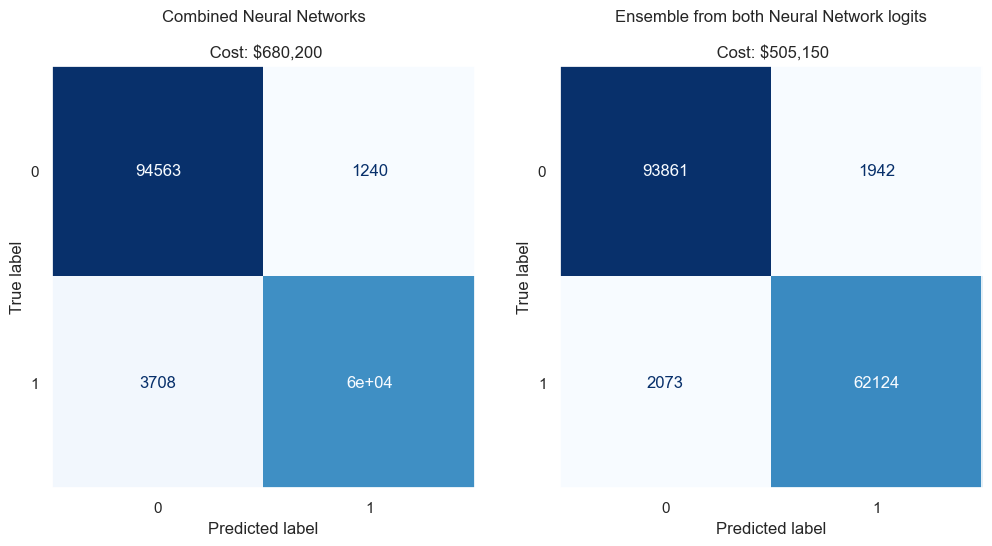

In [53]:
fig, ax = plt.subplots(1,2,figsize= (12,6))

disp1 = ConfusionMatrixDisplay(cm_preds_nn).plot(ax = ax[0],cmap = 'Blues', colorbar=False)
ax[0].set_title('Combined Neural Networks'+ '\n\n' + ' Cost: '+ '$'+ str(f'{cost_nn:,}'), fontsize = 12)
ax[0].grid(False)

disp3 = ConfusionMatrixDisplay(cm_preds_ens_log).plot(ax = ax[1],cmap = 'Blues', colorbar=False)
ax[1].set_title('Ensemble from both Neural Network logits'+ '\n\n' + ' Cost: '+ '$'+ str(f'{cost_ens_log:,}'), fontsize = 12)
ax[1].grid(False)

In [ ]:
y_alt['preds_nn']=preds_nn
y_alt['preds_ens']=preds_ens
y_alt['preds_ens2']=preds_ens2


y_alt.to_csv('results.csv', encoding = 'utf-8-sig')
files.download('results.csv')

<ipython-input-174-f5d109dfe8d8>:6: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  y_alt.to_csv('results.csv', encoding = 'utf-8-sig')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>